# Wildfire Data Visualization

This notebook loads processed fire data and creates visualizations to help understand wildfire patterns in California.

## Setup

First, let's import the necessary libraries and set up our environment.

In [ ]:
import os
import sys
import yaml
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

# Add the src directory to the path so we can import our package
src_dir = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))), 'src')
sys.path.append(src_dir)

# Import visualization functions
from wildfire_prediction.data import get_project_paths
from wildfire_prediction.visualization import (
    visualize_frp_distribution,
    visualize_california_fires
)

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## Load Configuration and Project Paths

We'll load the project configuration to get the paths to our data files.

In [ ]:
# Load configuration
config_path = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))),
                          'configs', 'config.yml')

# Get project paths
paths = get_project_paths(config_path)

# Print paths for verification
print(f"Project root: {paths['project_root']}")
print(f"Processed data path: {paths['processed_fire_data']}")
print(f"Figures output path: {paths['figures']}")

## Load Processed Fire Data

Now we'll load the processed wildfire data from the CSV file.

In [ ]:
# Load processed data
print(f"Loading processed data from {paths['processed_fire_data']}...")

# Check if file exists
if not os.path.exists(paths['processed_fire_data']):
    raise FileNotFoundError(f"Processed fire data file not found at: {paths['processed_fire_data']}")

# Load the data
df = pd.read_csv(paths['processed_fire_data'])

# Display basic information
print(f"Loaded {len(df):,} rows of fire data")
print("\nDataFrame columns:")
print(df.columns.tolist())

# Display the first few rows
df.head()

## Load California Boundary Data

We'll load the California boundary data for our map visualization.

In [ ]:
# Check if California geojson exists in the current directory
california_geojson = 'california.geojson'

if os.path.exists(california_geojson):
    print(f"Loading California boundary from {california_geojson}...")
    california = gpd.read_file(california_geojson)
else:
    print(f"{california_geojson} not found. Loading from original source...")
    # Load from original source
    states = gpd.read_file(paths['ca_boundary'])
    california = states[states.STATEFP == "06"]  # '06' is California's FIPS code
    
    # Save for future use
    california.to_file(california_geojson, driver="GeoJSON")
    
print(f"California boundary loaded successfully with {len(california)} features")

## Convert DataFrame to GeoDataFrame

For spatial visualizations, we need to convert our DataFrame to a GeoDataFrame with Point geometries.

In [ ]:
# Convert DataFrame to GeoDataFrame for map visualization
if 'geometry' not in df.columns:
    print("Converting DataFrame to GeoDataFrame for visualization...")
    geometry = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
else:
    gdf = gpd.GeoDataFrame(df)
    
print(f"GeoDataFrame created with {len(gdf):,} points")

# Display the first few rows
gdf.head()

## Create FRP Distribution Visualizations

Now we'll create visualizations of the Fire Radiative Power (FRP) distribution.

Creating FRP distribution visualizations...


d:\college\computer science level 3\second term\data science\wildfire_prediction\wildfire_prediction\src\wildfire_prediction\visualization\visualize.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(output_dir, 'frp_distribution.png'), bbox_inches='tight', dpi=300)


FRP distribution visualizations saved to: d:\college\computer science level 3\second term\data science\wildfire_prediction\wildfire_prediction\artifacts/figures


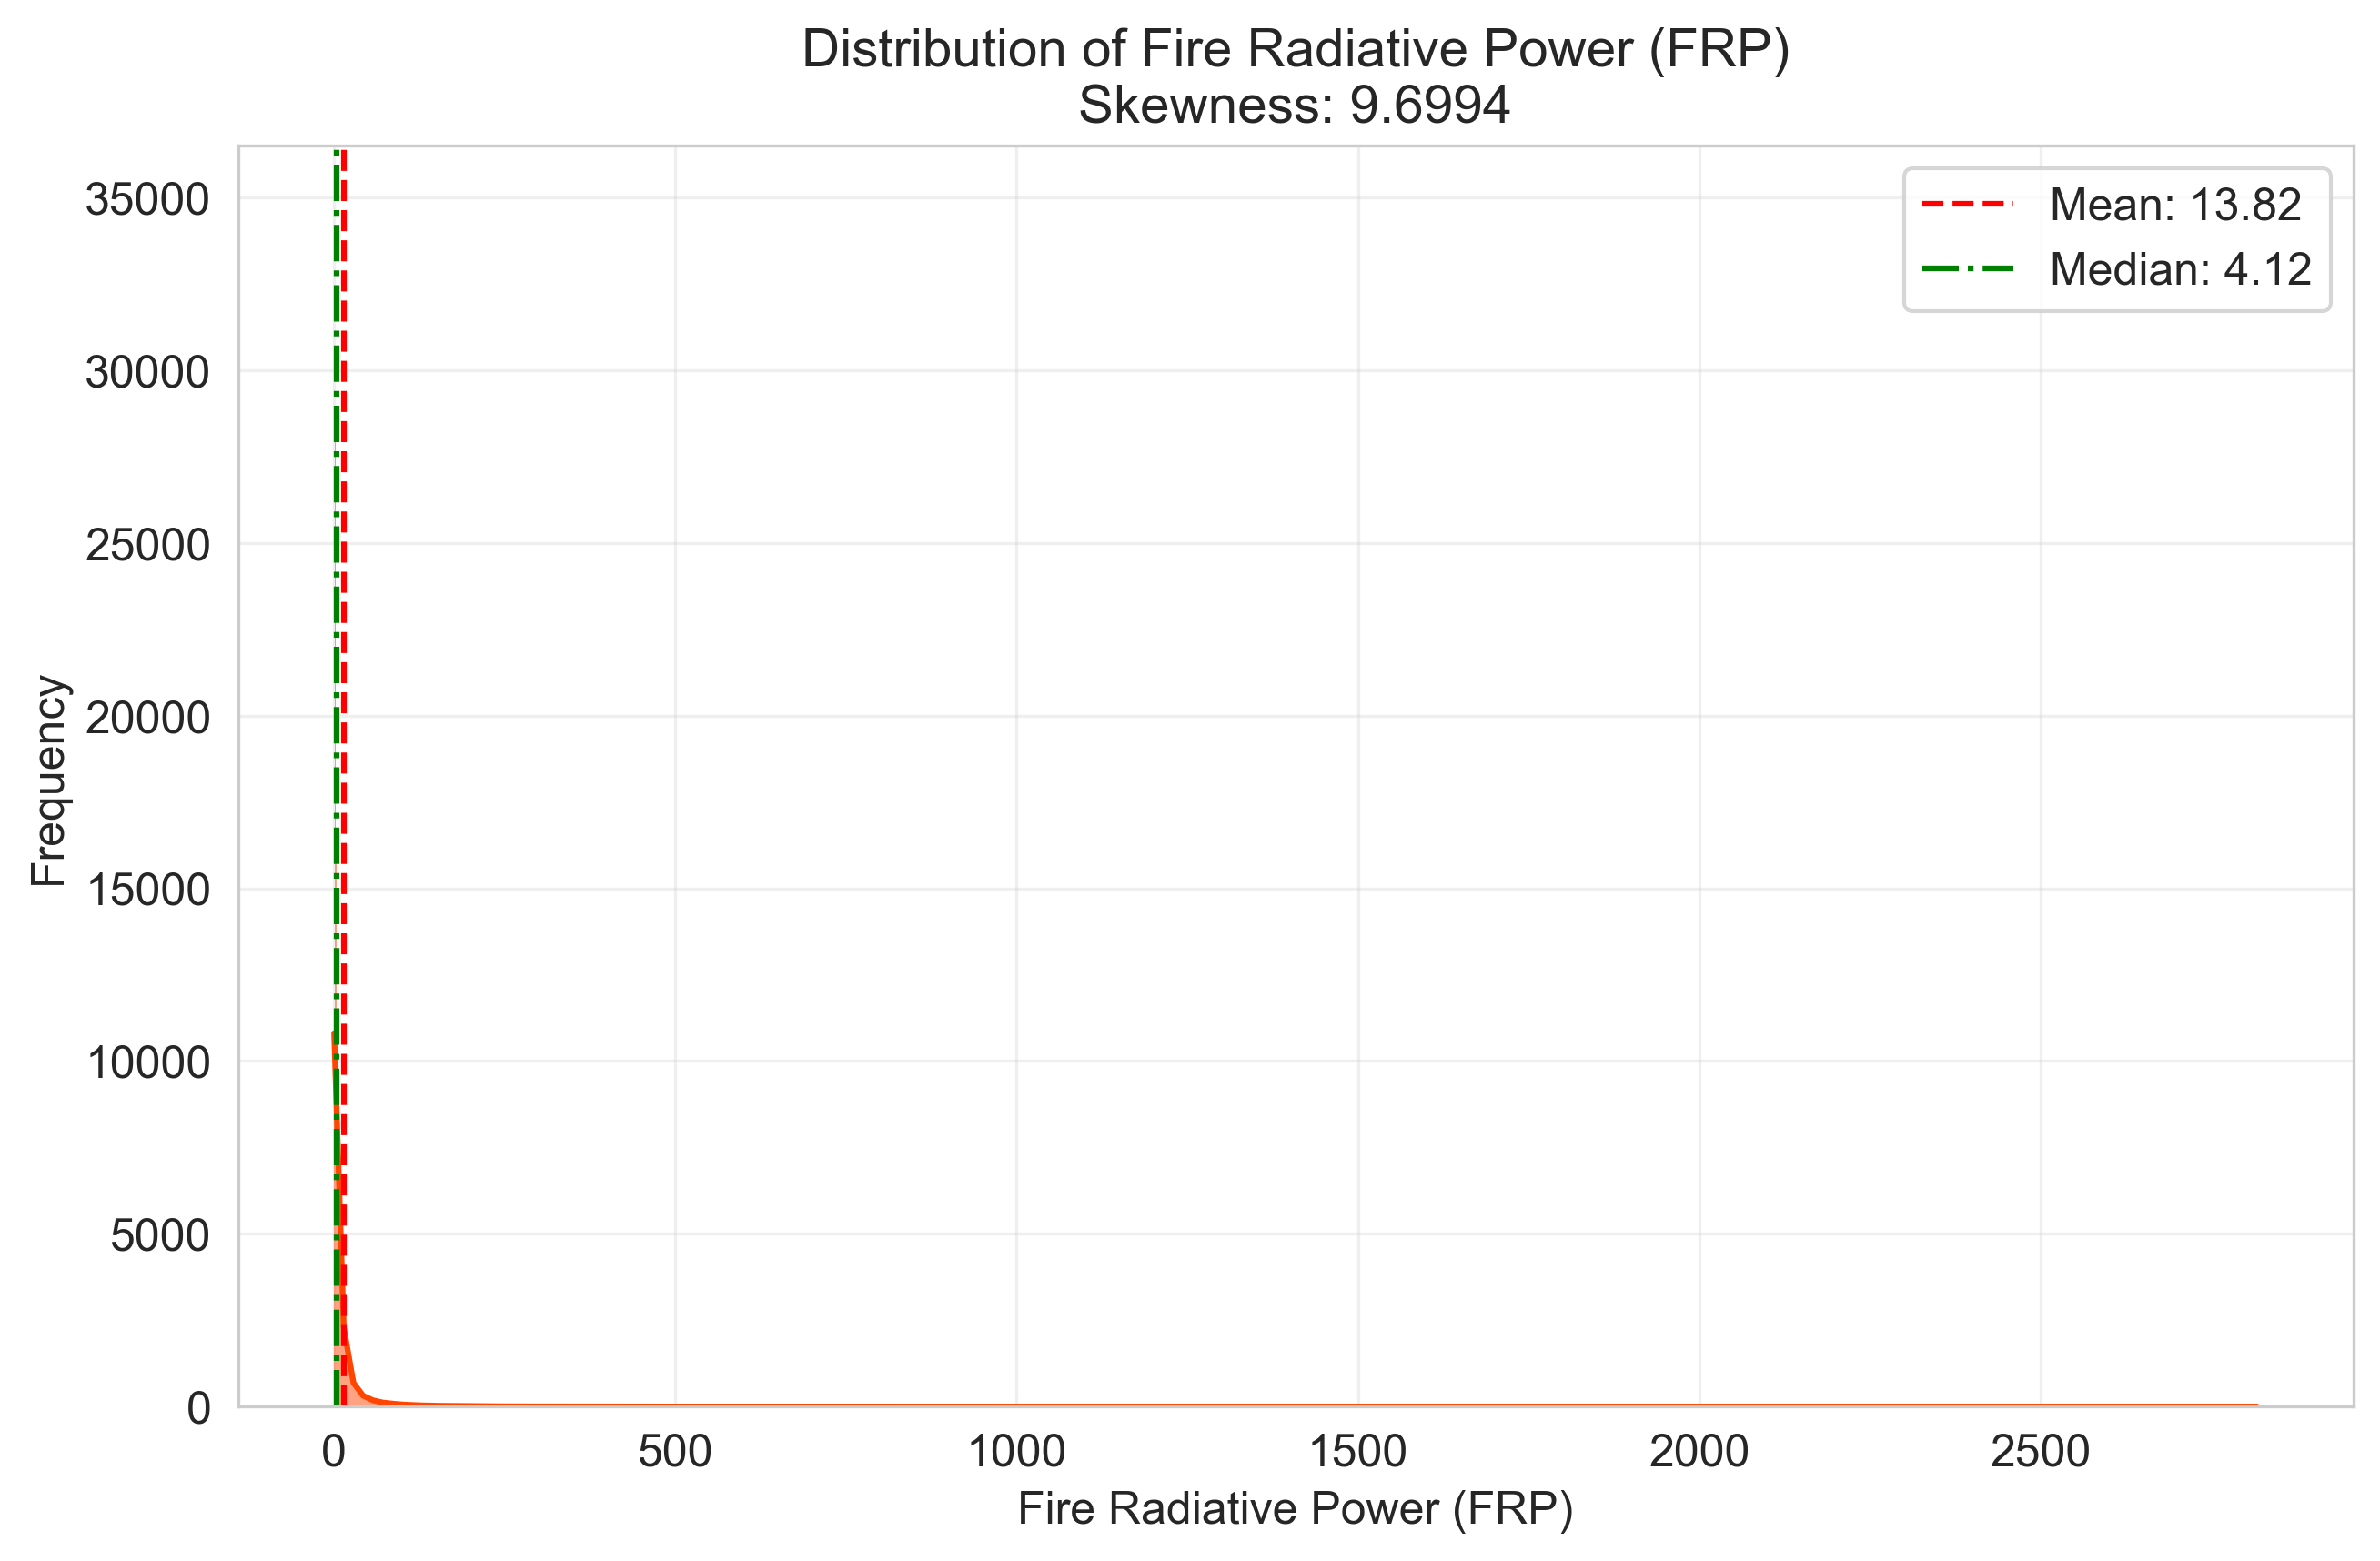

In [10]:
# Create FRP distribution visualizations
print("Creating FRP distribution visualizations...")

# Ensure figures directory exists
os.makedirs(paths['figures'], exist_ok=True)

# Create the visualization
visualize_frp_distribution(df, paths['figures'])

# Display the saved visualization
frp_dist_path = os.path.join(paths['figures'], 'frp_distribution.png')
if os.path.exists(frp_dist_path):
    from IPython.display import Image, display
    display(Image(frp_dist_path))
else:
    print(f"Warning: Visualization file not found at {frp_dist_path}")

## Create California Wildfires Map

Finally, we'll create a map visualization of wildfire data points in California.

Creating California wildfires map...
Sampled to 10000 points for visualization


AttributeError: Line2D.set() got an unexpected keyword argument 'legend_kwds'

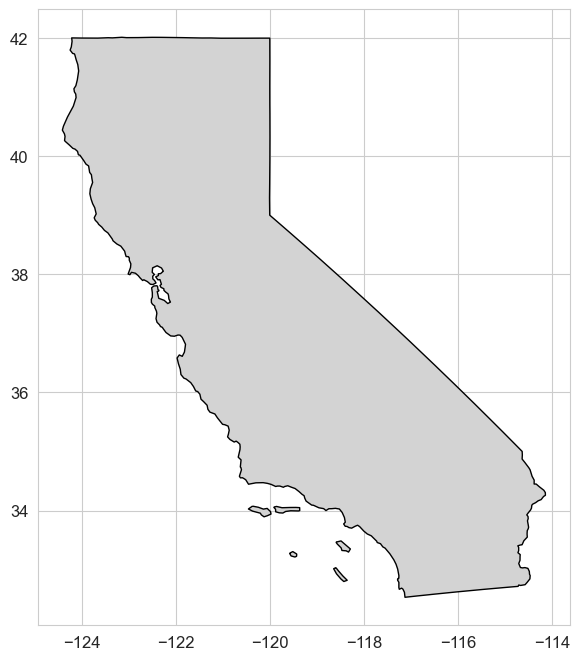

In [7]:
# Create California wildfires map
print("Creating California wildfires map...")

# Create the visualization
visualize_california_fires(gdf, california, paths['figures'])

# Display the saved visualization
ca_fires_path = os.path.join(paths['figures'], 'california_wildfires.png')
if os.path.exists(ca_fires_path):
    from IPython.display import Image, display
    display(Image(ca_fires_path))
else:
    print(f"Warning: Visualization file not found at {ca_fires_path}")

## Create Custom Visualizations

Let's create some additional custom visualizations to explore the data further.

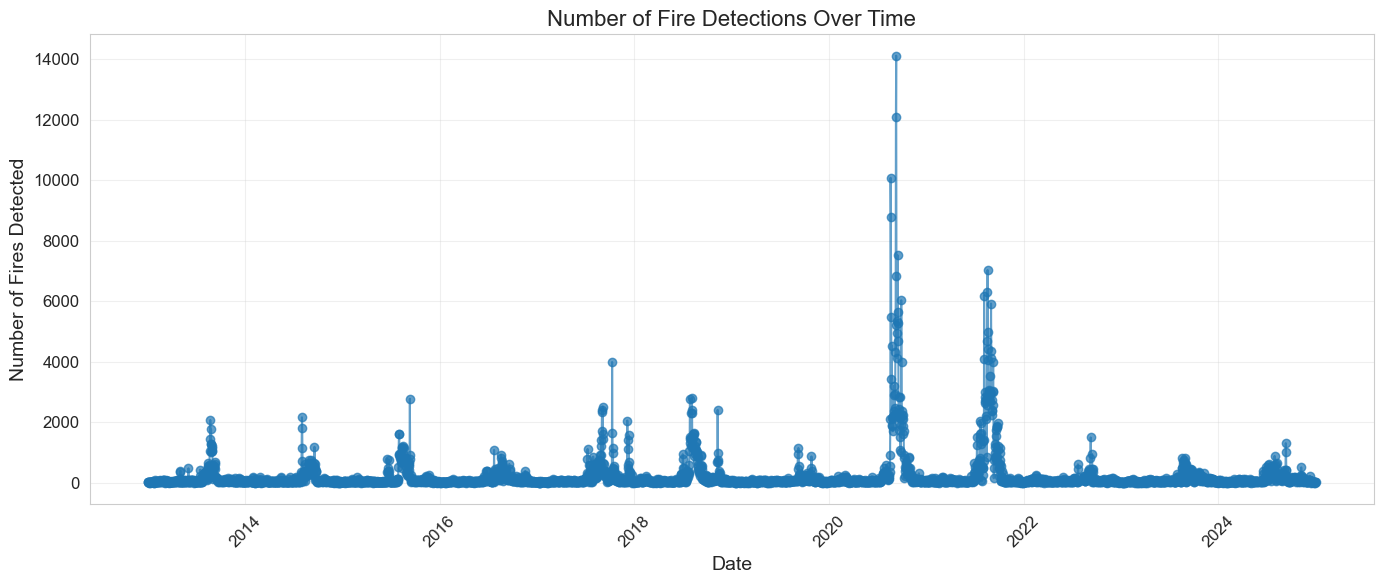

In [8]:
# Check if we have temporal data
if 'acq_date' in df.columns:
    # Convert to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df['acq_date']):
        df['acq_date'] = pd.to_datetime(df['acq_date'])
    
    # Group by date and count fires
    fires_by_date = df.groupby(df['acq_date'].dt.date).size().reset_index()
    fires_by_date.columns = ['date', 'fire_count']
    
    # Plot time series
    plt.figure(figsize=(14, 6))
    plt.plot(fires_by_date['date'], fires_by_date['fire_count'], marker='o', linestyle='-', alpha=0.7)
    plt.title('Number of Fire Detections Over Time', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Number of Fires Detected', fontsize=14)
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save the figure
    time_series_path = os.path.join(paths['figures'], 'fires_over_time.png')
    plt.savefig(time_series_path, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No acquisition date column found for temporal analysis")

Sampled to 10,000 points for heatmap visualization


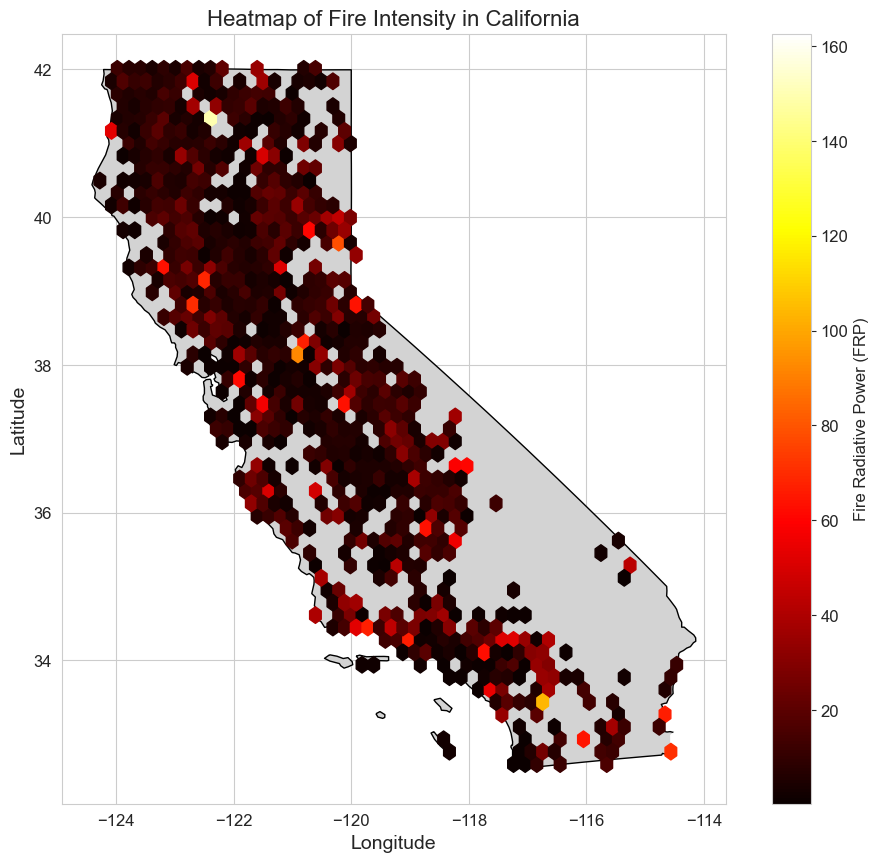

In [9]:
# Create a heatmap of fire intensity if we have the data
if all(col in df.columns for col in ['latitude', 'longitude', 'frp']):
    plt.figure(figsize=(12, 10))
    
    # Plot California boundary
    california.plot(ax=plt.gca(), color='lightgrey', edgecolor='black')
    
    # Sample data if it's too large (for better visualization)
    plot_data = df
    if len(df) > 10000:
        plot_data = df.sample(10000, random_state=42)
        print(f"Sampled to {len(plot_data):,} points for heatmap visualization")
    
    # Create heatmap using hexbin
    hb = plt.hexbin(plot_data['longitude'], plot_data['latitude'], C=plot_data['frp'],
                   gridsize=50, cmap='hot', mincnt=1)
    
    # Add colorbar
    cb = plt.colorbar(hb)
    cb.set_label('Fire Radiative Power (FRP)')
    
    plt.title('Heatmap of Fire Intensity in California', fontsize=16)
    plt.xlabel('Longitude', fontsize=14)
    plt.ylabel('Latitude', fontsize=14)
    
    # Save the figure
    heatmap_path = os.path.join(paths['figures'], 'fire_intensity_heatmap.png')
    plt.savefig(heatmap_path, dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Missing required columns for heatmap visualization")

## Summary

In this notebook, we've created several visualizations of California wildfire data:

1. Distribution of Fire Radiative Power (FRP)
2. Map of wildfire locations in California
3. Time series of fire detections (if temporal data available)
4. Heatmap of fire intensity across California

These visualizations help us understand the spatial and temporal patterns of wildfires in California, as well as their intensity distribution.

Successfully loaded 6144108 rows

Confidence Categories:
Category: 'n' - Count: 5534668 (90.08%)
Category: 'h' - Count: 351639 (5.72%)
Category: 'l' - Count: 257801 (4.20%)

Visualization saved to: d:\college\computer science level 3\second term\data science\wildfire_prediction\wildfire_prediction\artifacts/figures\confidence_distribution.png


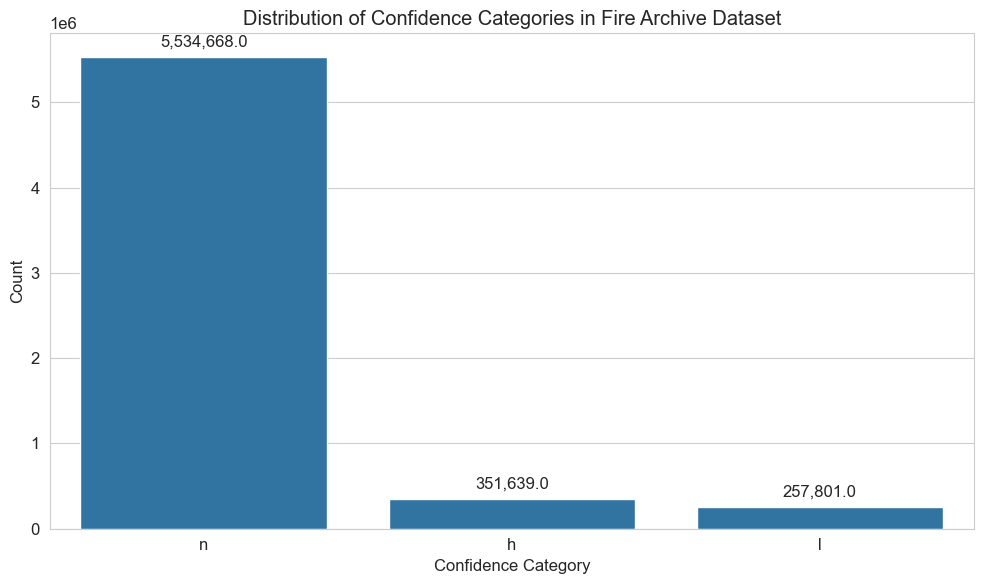

In [11]:
# Load the raw data
try:
    df = pd.read_csv(paths['fire_data'])
    print(f"Successfully loaded {len(df)} rows")
    
    # Check if confidence column exists
    if 'confidence' not in df.columns:
        print("Error: 'confidence' column not found in the dataset")
    
    
    # Get unique confidence values and their counts
    confidence_counts = df['confidence'].value_counts().reset_index()
    confidence_counts.columns = ['confidence', 'count']
    
    # Print the results
    print("\nConfidence Categories:")
    print("=====================")
    for _, row in confidence_counts.iterrows():
        print(f"Category: '{row['confidence']}' - Count: {row['count']} ({row['count']/len(df)*100:.2f}%)")
    
    # Create a visualization
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='confidence', y='count', data=confidence_counts)
    
    # Add count labels on top of bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():,}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom', 
                xytext = (0, 5), textcoords = 'offset points')
    
    plt.title('Distribution of Confidence Categories in Fire Archive Dataset')
    plt.xlabel('Confidence Category')
    plt.ylabel('Count')
    plt.tight_layout()
    
    # Create figures directory if it doesn't exist
    os.makedirs(paths['figures'], exist_ok=True)
    
    # Save the figure
    output_path = os.path.join(paths['figures'], 'confidence_distribution.png')
    plt.savefig(output_path)
    print(f"\nVisualization saved to: {output_path}")
    
    # Show the plot
    plt.show()
    
except Exception as e:
    print(f"Error analyzing confidence categories: {e}")